In [10]:
import pickle
import pathlib
import os
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder


In [5]:
PROJECT_PATH = os.getcwd()
PROJECT_PATH = os.path.join(PROJECT_PATH, "..")
MODELS_DIR = pathlib.Path(PROJECT_PATH) / "store" / "models"

DATASET_DIR = pathlib.Path(PROJECT_PATH) / "data"

PosixPath('/Users/eden.yavin/Projects/Tabular-Cloud-ML/notebooks/../data')

In [8]:
import pandas as pd

dataset = pd.read_csv(DATASET_DIR / "heloc"/ "dataset.csv")
dataset

,RiskPerformance,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,...,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
0,Bad,55,144,4,84,20,3,0,83,2,...,43,0,0,0,33,-8,8,1,1,69
1,Bad,61,58,15,41,2,4,4,100,-7,...,67,0,0,0,0,-8,0,-8,-8,0
2,Bad,67,66,5,24,9,0,0,100,-7,...,44,0,4,4,53,66,4,2,1,86
3,Bad,66,169,1,73,28,1,1,93,76,...,57,0,5,4,72,83,6,4,3,91
4,Bad,81,333,27,132,12,0,0,100,-7,...,25,0,1,1,51,89,3,1,0,80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10454,Good,73,131,5,57,21,0,0,95,80,...,19,7,0,0,26,-8,5,2,0,100
10455,Bad,65,147,39,68,11,0,0,92,28,...,42,1,1,1,86,53,2,2,1,80
10456,Bad,74,129,6,64,18,1,1,100,-7,...,33,3,4,4,6,-8,5,-8,0,56
10457,Bad,72,234,12,113,42,2,2,96,35,...,20,6,0,0,19,-8,4,1,0,38


In [9]:
X, y = dataset.iloc[:, 1:], dataset.iloc[:, 0]

# Remove the bug in the dataset where the entire row has -9 values
mask = ~(X == -9).all(axis=1)
X = X[mask]
y = y[mask]

y = y.replace({"Bad": 0, "Good": 1}).astype(int)

/var/folders/r9/9n0wpy917zg1611cmsmqg0kr0000gn/T/ipykernel_18314/1116483927.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace({"Bad": 0, "Good": 1}).astype(int)


In [138]:
def preprocess(X: pd.DataFrame, cloud_dataset=False):
    """
    The function will preprocess the data:
    1. Categorical features will be label encoded (Boy->1, Girl ->2)
    2. Numerical features will be scaled if the data is intended to be used for baseline. For cloud data set, no scaling will be preformed.

    Return pd.Dataframe
    """
    # Identify categorical and numeric columns
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    numeric_cols = X.select_dtypes(include=['number']).columns.tolist()

    # Initialize lists to store processed columns
    processed_columns = []

    # If there are categorical columns, apply one-hot encoding
    if categorical_cols:
        print("\nEncoding categorical columns...")
        # onehot_encoder = OneHotEncoder(categories='auto', sparse=False)
        # X_categorical = pd.DataFrame(onehot_encoder.fit_transform(X[categorical_cols]),
        #                              columns=onehot_encoder.get_feature_names_out(categorical_cols))
        label_encoder = LabelEncoder()
        X_categorical = pd.DataFrame()
        for col in categorical_cols:
            X_categorical[col] = label_encoder.fit_transform(X[col])

        processed_columns.append(X_categorical)

    # Apply standard scaling to the numeric columns
    if numeric_cols:
        print("\nScaling numerical columns...")
        scaler = MinMaxScaler()
        X_numeric = X[numeric_cols]
        # if cloud_dataset:
        #     X_numeric = pd.DataFrame(scaler.fit_transform(X[numeric_cols]), columns=numeric_cols, index=X.index)
        # else:
        # X_numeric = pd.DataFrame(scaler.fit_transform(X[numeric_cols]), columns=numeric_cols, index=X.index)

        processed_columns.append(X_numeric)

    # Combine the processed columns
    if processed_columns:
        X_processed = pd.concat(processed_columns, axis=1)
    else:
        X_processed = X.copy()  # If there are no categorical or numeric columns, keep the original dataframe


    return X_processed


X = preprocess(X, cloud_dataset=True)


Scaling numerical columns...


In [139]:
import pandas as pd

from keras.src import Sequential
from keras.src.callbacks import EarlyStopping
from keras.src.layers import Dropout, Dense, BatchNormalization
import torch.nn as nn

from keras.src.utils import to_categorical


class DNNEmbedding(nn.Module):

    name = "dnn_embedding"

    def __init__(self, **kwargs):
        super(DNNEmbedding, self).__init__()

        X, y = kwargs.get("X"), kwargs.get("y")
        num_classes = len(set(y))
        y = to_categorical(y, num_classes=num_classes)

        model = Sequential()
        model.add(Dense(units=X.shape[1]//2, activation='tanh', name="embedding"))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))
        model.add(Dense(units=num_classes, activation='softmax', name="output"))

        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        early_stop = EarlyStopping(patience=2, monitor="loss")

        model.fit(X, y, epochs=50, batch_size=8, callbacks=[early_stop])
        self.model = model.layers[0]
        self.output_shape = (1, X.shape[1]//2)


    def forward(self, x):

        if type(x) is pd.DataFrame:
            x = x.to_numpy()

        embedding = self.model(x)
        return embedding


embedding = DNNEmbedding(X=X, y=y)



Epoch 1/50
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 1s 251us/step - accuracy: 0.5996 - loss: 0.8620
Epoch 2/50
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step - accuracy: 0.6652 - loss: 0.6155
Epoch 3/50
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step - accuracy: 0.6960 - loss: 0.5929
Epoch 4/50
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step - accuracy: 0.7080 - loss: 0.5854
Epoch 5/50
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 0s 237us/step - accuracy: 0.7012 - loss: 0.5876
Epoch 6/50
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step - accuracy: 0.7154 - loss: 0.5783
Epoch 7/50
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 0s 234us/step - accuracy: 0.7042 - loss: 0.5891
Epoch 8/50
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step - accuracy: 0.7095 - loss: 0.5786
Epoch 9/50
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step - accuracy: 0.7125 - loss: 0.5762
Epoch 10/50
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step - accuracy: 0.7135 - loss: 0.5788
Epoch 11/50
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step - accuracy: 0.7127 - loss: 0.5746


In [140]:
X_sample, y_sample = X.iloc[:100], y.iloc[:100]
y_sample.value_counts()

RiskPerformance
0    71
1    29
Name: count, dtype: int64

In [141]:
X_embed = embedding(X_sample)
X_embed.shape

TensorShape([100, 11])

In [142]:
from sklearn.decomposition import PCA
import numpy as np
np.random.seed(42)

pca = PCA(n_components=2)


X_reduced = pca.fit_transform(X_embed)


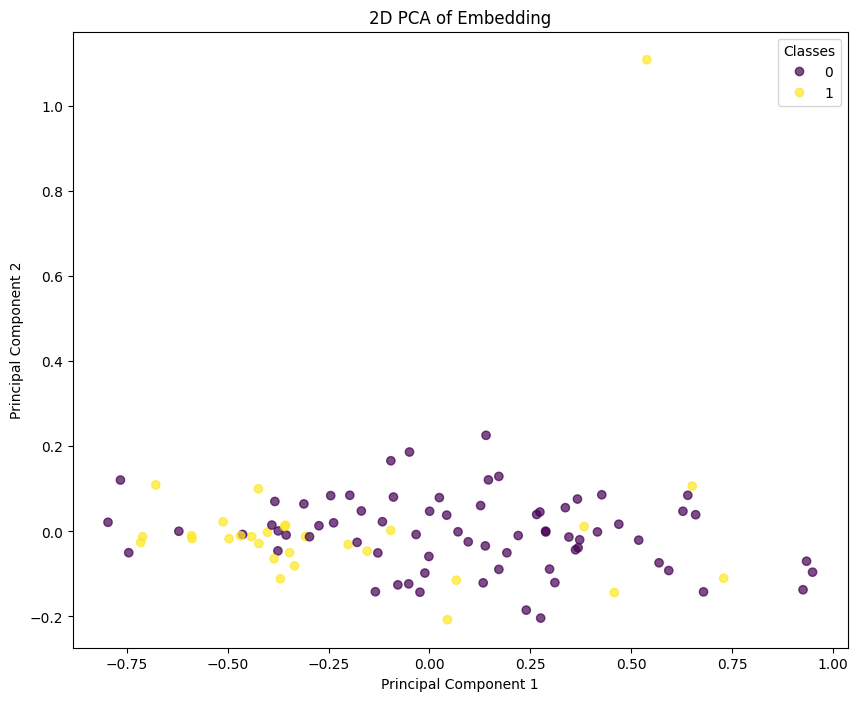

In [143]:
import matplotlib.pyplot as plt
# Create a scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_sample, cmap='viridis', alpha=0.7)

# Add a legend
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")

# Add titles and labels
plt.title('2D PCA of Embedding')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Show the plot
plt.show()

In [ ]:
import numpy as np
from keras.src.layers import Input, Dense,  Flatten
from keras.src.layers import BatchNormalization, Activation, Conv2DTranspose
from keras.src.models import Model, Sequential
from keras.src.layers import LeakyReLU, Reshape, Conv2D, UpSampling2D, ReLU

class BaseEncryptor:

    name: str

    def __init__(self, input_shape=None, output_shape=None):
        self.model = None
        self.output_shape = output_shape
        self.input_shape = input_shape

    def build_generator(self, input_shape, output_shape):
        raise NotImplementedError("Subclasses should implement this method")

    def encode(self, inputs) -> np.array:
        inputs = np.expand_dims(inputs, axis=0)
        if self.model is None:
            input_shape = inputs.shape[1:]
            output_shape = self.output_shape or (1, inputs.shape[2])
            self.model = self.build_generator(input_shape, output_shape)
        return self.model(inputs).numpy()

class DCEncryptor(BaseEncryptor):

    name = "dc"

    def build_generator(self, input_shape, output_shape):

        input_layer = Input(shape=input_shape)
        x = Flatten()(input_layer)

        x = Dense(7*7*256, use_bias=False)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)

        x = Reshape((7, 7, 256))(x)
        x = Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)

        x = Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)

        x = Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)

        x = Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)

        output_image = Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='sigmoid')(x)

        return Model(inputs=input_layer, outputs=output_image)
    
    
encoder = DCEncryptor(output_shape=(1, 224, 224, 3))

In [ ]:
X_encrypted = []

for i, x in X_sample.iterrows():
    
    x_embed = embedding(x.values.reshape(1,-1))
    encrypted = encoder.encode(np.vstack(x_embed))
    encrypted = (encrypted * 10000).astype(np.uint8)

    X_encrypted.append(encrypted)

In [150]:
from scipy.spatial import distance


distance_between_1 = []
distance_between_0 = []
distance_between_diff_label = []

i = 0
for u, y1 in zip(X_encrypted, y_sample):
    j = 0
    for v, y2 in zip(X_encrypted, y_sample):
        euc_dis = distance.euclidean(u.flatten(), v.flatten())
        if y1 == 1 and y2 == 1 and i != j:
            distance_between_1.append(euc_dis)
        elif y1 == 0 and y2 == 0 and i != j:
            distance_between_0.append(euc_dis)
        elif y1 != y2 and i != j:
            distance_between_diff_label.append(euc_dis)
        j += 1
        
    i += 1
            
        

In [151]:
np.mean(distance_between_1)

27766.191507923293

In [152]:
np.mean(distance_between_0)


28159.905748000063

In [155]:
np.mean(distance_between_diff_label)

30197.96594969774